In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, StratifiedShuffleSplit, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.feature_selection import SelectFromModel, VarianceThreshold, SelectKBest, f_classif, chi2
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from scipy import stats
from sklearn.externals import joblib

In [3]:
conn = pd.read_csv("RESULTS_C_D_E_DE_KONDRATEVA_10.12.csv")
thickness_lh = pd.read_csv("mri_features/th_lh_last.csv", index_col=0)
thickness_rh = pd.read_csv("mri_features/th_rh_last.csv", index_col=0)
thickness = thickness_lh.join(thickness_rh, lsuffix="_lh", rsuffix="_rh")
volumes = pd.read_csv("mri_features/vol_last.csv", index_col=0)
info = pd.read_csv("таблица_10102017.csv", index_col=0, header=1)

target = conn.target
# 4 classes (С(0), D(1), E(2), DE(3))
D_target = np.int8(np.logical_or(target == "D", target == "DE"))
E_target = np.int8(np.logical_or(target == "E", target == "DE")) * 2
DE_target = D_target + E_target
EC_idx = np.logical_or(target == "E", target == "С") # "C" - rus
DC_idx = np.logical_or(target == "D", target == "С") # "C" - rus
DEE_idx = np.logical_or(target == "E", target == "DE") # "C" - rus

idx = np.argsort(thickness.index)
thickness = thickness.iloc[idx].drop(["target_lh", "target_rh"], axis=1).reset_index(drop=True)
volumes = volumes.iloc[idx].reset_index(drop=True)

mri_data = thickness.join(volumes)
conn.drop(["index", "target"], axis=1, inplace=True)

all_data = thickness.join(volumes).join(conn)

# indicators for NaN values
conn_nan = pd.DataFrame(conn.loc[:, conn.isnull().any(axis=0)].isnull(), dtype=int)
conn = conn.join(conn_nan, rsuffix="_nan")
all_data_nan = pd.DataFrame(all_data.loc[:, all_data.isnull().any(axis=0)].isnull(), dtype=int)
all_data = all_data.join(all_data_nan, rsuffix="_nan")

In [4]:
mri_data.head()

,bankssts_NumVert_lh,caudalanteriorcingulate_NumVert_lh,caudalmiddlefrontal_NumVert_lh,cuneus_NumVert_lh,entorhinal_NumVert_lh,fusiform_NumVert_lh,inferiorparietal_NumVert_lh,inferiortemporal_NumVert_lh,isthmuscingulate_NumVert_lh,lateraloccipital_NumVert_lh,...,Right-WM-hypointensities_normRange,non-WM-hypointensities_normRange,Left-non-WM-hypointensities_normRange,Right-non-WM-hypointensities_normRange,Optic-Chiasm_normRange,CC_Posterior_normRange,CC_Mid_Posterior_normRange,CC_Central_normRange,CC_Mid_Anterior_normRange,CC_Anterior_normRange
0,1794,1030,3395,2525,660,6353,7740,5702,1631,9444,...,0.0,0.0,0.0,0.0,86.0,79.0,105.0,77.0,73.0,84.0
1,1893,1117,4504,2560,845,5522,10129,7056,1707,9203,...,0.0,0.0,0.0,0.0,94.0,78.0,108.0,97.0,90.0,92.0
2,1089,900,2295,2624,666,4210,6247,5159,1575,7472,...,0.0,0.0,0.0,0.0,83.0,94.0,95.0,97.0,81.0,129.0
3,1624,1755,3126,2859,614,4284,6865,4909,1688,9196,...,0.0,0.0,0.0,0.0,90.0,79.0,96.0,94.0,119.0,117.0
4,1377,1186,4497,3258,503,5292,7041,6269,1647,9720,...,0.0,0.0,0.0,0.0,110.0,71.0,76.0,85.0,77.0,111.0


In [5]:
conn.head()

,GlobalEfficiency,LocalEfficiency,BetweennessCentrality,Cost,AveragePathLength,ClusteringCoefficient,Degree,GlobalEfficiency.1,LocalEfficiency.1,BetweennessCentrality.1,...,AveragePathLength.151_nan,ClusteringCoefficient.151_nan,LocalEfficiency.152_nan,ClusteringCoefficient.152_nan,LocalEfficiency.163_nan,AveragePathLength.163_nan,ClusteringCoefficient.163_nan,LocalEfficiency.164_nan,AveragePathLength.164_nan,ClusteringCoefficient.164_nan
0,0.478010,0.704474,0.005351,0.150007,2.009585,0.459322,24.45122,0.465746,0.693056,0.002158,...,0,0,0,0,0,0,0,0,0,0
1,0.517856,0.683139,0.006479,0.150007,2.089286,0.444154,24.45122,0.530675,0.647563,0.006125,...,0,0,0,0,0,0,0,0,0,0
2,0.530009,0.671200,0.006993,0.150007,2.132874,0.427119,24.45122,0.549080,0.684710,0.007908,...,0,0,0,0,0,0,0,0,0,0
3,0.534979,0.656800,0.006761,0.150007,2.095242,0.411642,24.45122,0.558282,0.736015,0.004418,...,0,0,0,0,0,0,0,0,0,0
4,0.507196,0.693416,0.007251,0.150007,2.203972,0.479904,24.45122,0.620143,0.694297,0.024515,...,0,0,0,0,0,0,0,0,0,0


In [6]:
all_data.head()

,bankssts_NumVert_lh,caudalanteriorcingulate_NumVert_lh,caudalmiddlefrontal_NumVert_lh,cuneus_NumVert_lh,entorhinal_NumVert_lh,fusiform_NumVert_lh,inferiorparietal_NumVert_lh,inferiortemporal_NumVert_lh,isthmuscingulate_NumVert_lh,lateraloccipital_NumVert_lh,...,AveragePathLength.151_nan,ClusteringCoefficient.151_nan,LocalEfficiency.152_nan,ClusteringCoefficient.152_nan,LocalEfficiency.163_nan,AveragePathLength.163_nan,ClusteringCoefficient.163_nan,LocalEfficiency.164_nan,AveragePathLength.164_nan,ClusteringCoefficient.164_nan
0,1794,1030,3395,2525,660,6353,7740,5702,1631,9444,...,0,0,0,0,0,0,0,0,0,0
1,1893,1117,4504,2560,845,5522,10129,7056,1707,9203,...,0,0,0,0,0,0,0,0,0,0
2,1089,900,2295,2624,666,4210,6247,5159,1575,7472,...,0,0,0,0,0,0,0,0,0,0
3,1624,1755,3126,2859,614,4284,6865,4909,1688,9196,...,0,0,0,0,0,0,0,0,0,0
4,1377,1186,4497,3258,503,5292,7041,6269,1647,9720,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# отбор признаков на основе модели
# аналогично SelectFromModel, но на основе количества признаков, а не порога

from sklearn.base import BaseEstimator, MetaEstimatorMixin, clone
from sklearn.feature_selection.base import SelectorMixin
from sklearn.feature_selection.from_model import _get_feature_importances
from sklearn.utils.metaestimators import if_delegate_has_method

class SelectNFeaturesFromModel(BaseEstimator, SelectorMixin, MetaEstimatorMixin):
    def __init__(self, estimator, n_selected, prefit=False):
        self.estimator = estimator
        self.n_selected = n_selected
        self.prefit = prefit

    def _get_support_mask(self):
        if self.prefit:
            estimator = self.estimator
        elif hasattr(self, 'estimator_'):
            estimator = self.estimator_
        else:
            raise ValueError(
                'Either fit SelectFromModel before transform or set "prefit='
                'True" and pass a fitted estimator to the constructor.')
        scores = _get_feature_importances(estimator)
        threshold = np.sort(scores)[-self.n_selected]
        return scores >= threshold

    def fit(self, X, y=None, **fit_params):
        if self.prefit:
            raise NotFittedError(
                "Since 'prefit=True', call transform directly")
        self.estimator_ = clone(self.estimator)
        self.estimator_.fit(X, y, **fit_params)
        return self

    @property
    def threshold_(self):
        scores = _get_feature_importances(self.estimator_, self.norm_order)
        return np.sort(scores)[-n_selected]
    
    @if_delegate_has_method('estimator')
    def partial_fit(self, X, y=None, **fit_params):
        if self.prefit:
            raise NotFittedError(
                "Since 'prefit=True', call transform directly")
        if not hasattr(self, "estimator_"):
            self.estimator_ = clone(self.estimator)
        self.estimator_.partial_fit(X, y, **fit_params)
        return self

In [8]:
def get_svc_grid(cv, dim_reduction_methods, random_state=None,
                 svc_kernel_l=None, svc_c_l=None, svc_gamma_l=None):

    pipe = Pipeline([
        ("Fill_NaN", Imputer(strategy="median")),
        ('StdScaler', StandardScaler()),
        ("VarTh", VarianceThreshold()),
        ('dim_reduction', SelectKBest(stats.ttest_ind)),
        ('classifier', SVC(random_state=random_state)),
    ])

    param_grid = {
        'dim_reduction': dim_reduction_methods,
    }
    if svc_kernel_l is not None:
        param_grid['classifier__kernel'] = svc_kernel_l
    if svc_c_l is not None:
        param_grid['classifier__C'] = svc_c_l
    if svc_gamma_l is not None:
        param_grid['classifier__gamma'] = svc_gamma_l
    
    return GridSearchCV(estimator=pipe, param_grid=param_grid, scoring="accuracy", cv=cv)

In [9]:
def get_lr_grid(cv, dim_reduction_methods, random_state=None,
                 lr_c_l=None):
    
    pipe = Pipeline([
        ("Fill_NaN", Imputer(strategy="median")),
        ('StdScaler', StandardScaler()),
        ("VarTh", VarianceThreshold()),
        ('dim_reduction', SelectKBest(stats.ttest_ind)),
        ('classifier', LogisticRegression(random_state=random_state)),
    ])

    param_grid = {
        'dim_reduction': dim_reduction_methods,
    }
    if lr_c_l is not None:
        param_grid['classifier__C'] = lr_c_l
    
    return GridSearchCV(estimator=pipe, param_grid=param_grid, scoring="accuracy", cv=cv)

In [10]:
def get_rfc_grid(cv, dim_reduction_methods, random_state=None,
                 rfc_n_estimators_l=None):
    
    pipe = Pipeline([
        ("Fill_NaN", Imputer(strategy="median")),
        ('StdScaler', StandardScaler()),
        ("VarTh", VarianceThreshold()),
        ('dim_reduction', SelectKBest(stats.ttest_ind)),
        ('classifier', RandomForestClassifier(random_state=random_state)),
    ])

    param_grid = {
        'dim_reduction': dim_reduction_methods,
    }
    if rfc_n_estimators_l is not None:
        param_grid['classifier__n_estimators'] = rfc_n_estimators_l
    
    return GridSearchCV(estimator=pipe, param_grid=param_grid, scoring="accuracy", cv=cv)

In [11]:
def get_knn_grid(cv, dim_reduction_methods, random_state=None,
                 knn_n_neighbors_l=None, knn_weights_l=None, knn_p_l=None):
    
    pipe = Pipeline([
        ("Fill_NaN", Imputer(strategy="median")),
        ('StdScaler', StandardScaler()),
        ("VarTh", VarianceThreshold()),
        ('dim_reduction', SelectKBest(stats.ttest_ind)),
        ('classifier', KNeighborsClassifier()),
    ])

    param_grid = {
        'dim_reduction': dim_reduction_methods,
    }
    if knn_n_neighbors_l is not None:
        param_grid['classifier__n_neighbors'] = knn_n_neighbors_l
    if knn_weights_l is not None:
        param_grid['classifier__weights'] = knn_weights_l
    if knn_p_l is not None:
        param_grid['classifier__p'] = knn_p_l
    
    return GridSearchCV(estimator=pipe, param_grid=param_grid, scoring="accuracy", cv=cv)

In [12]:
# set printoptions
pd.set_option('expand_frame_repr', True)
pd.set_option('max_colwidth', 150)

In [13]:
def print_results(clf_grid_dict):
    results = {
            "classifier" : [], 
            "best parameters" : [],
            "best dim. reduction method" : [],
            "mean" : [],
            "std" : []
           }
    
    for clf, grid in clf_grid_dict.items():
        results["classifier"].append(clf)
        results["best parameters"].append(", ".join(
            [param + " = " + str(best_value) for param, best_value in grid.best_params_.items() if param != 'dim_reduction']))
        results["best dim. reduction method"].append(grid.best_params_['dim_reduction'])
        idx = grid.best_index_
        results["mean"].append(grid.cv_results_['mean_test_score'][idx])
        results["std"].append(grid.cv_results_['std_test_score'][idx])
        
    results = pd.DataFrame(results, columns=["classifier", "best parameters", "best dim. reduction method", "mean", "std"])
    display(results.set_index("classifier"))
    
    # draw graph
    width = 0.9
    for i in results.index:
        plt.bar(i, results.loc[i, "mean"], width, yerr=results.loc[i, "std"], label=results.loc[i, "classifier"])
    plt.xticks(range(results.shape[0]), results.loc[:, "classifier"])
    plt.axis(ymin=0.0, ymax=1.0)
    plt.show()
    
    print("Best model: ")
    clf = results.loc[results["mean"].argmax(), "classifier"]
    print(clf)
    print("\n".join(
            [param + " = " + str(best_value) for param, best_value in clf_grid_dict[clf].best_params_.items()]))
    print()
    print("mean =", results["mean"].max())
    print("std =", results.loc[results["mean"].argmax(), "std"])

### Объединенный подсчет и сравнение всех классификаторов (SVC, LR, RFC, KNN)

In [14]:
def train_grid_cv(X, y, n_splits, n_repeats, random_state=None):
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    
    n_features = [5, 10, 20, 50, 100]
    n_components = [2, 3, 5, 10, 15, 20]
    
    # list of dimensionality reduction methods
    # ради экономии времени не проверялись некоторые методы снижения размерности (они закомментированы), 
    # можно раскомментировать и проверить их тоже
    dim_reduction_methods = []
    dim_reduction_methods += [SelectKBest(stats.ttest_ind, n) for n in n_features]
    dim_reduction_methods += [SelectKBest(f_classif, n) for n in n_features]
#     dim_reduction_methods += [SelectNFeaturesFromModel(RandomForestClassifier(n_estimators=100, random_state=random_state), n) for n in n_features]
#     dim_reduction_methods += [SelectNFeaturesFromModel(LogisticRegression(), n) for n in n_features]
#     dim_reduction_methods += [SelectNFeaturesFromModel(ExtraTreesClassifier(n_estimators=100, random_state=random_state), n) for n in n_features]
    dim_reduction_methods += [PCA(n) for n in n_components]
#     dim_reduction_methods += [LocallyLinearEmbedding(n_components=n, random_state=random_state) for n in n_components]
    
    
    print("Training SVC...")
    grid_cv_svc = get_svc_grid(cv, dim_reduction_methods, random_state=random_state,
                               svc_kernel_l=["rbf", "linear"],
                               svc_c_l=[10 ** i for i in range(-6, 4, 2)],
                               svc_gamma_l=[10 ** i for i in range(-6, 2, 2)])
    start_time = time.time()
    grid_cv_svc.fit(X, y)
    print("(training took {}s)\n".format(time.time() - start_time))
    
    print("Training LR...")
    grid_cv_lr = get_lr_grid(cv, dim_reduction_methods, random_state=random_state,
                             lr_c_l=[10 ** i for i in range(-6, 2, 2)])
    start_time = time.time()
    grid_cv_lr.fit(X, y)
    print("(training took {}s)\n".format(time.time() - start_time))
    
    print("Training RFC...")
    grid_cv_rfc = get_rfc_grid(cv, dim_reduction_methods, random_state=random_state,
                               rfc_n_estimators_l=[i for i in range(300, 950, 150)])
    start_time = time.time()
    grid_cv_rfc.fit(X, y)
    print("(training took {}s)\n".format(time.time() - start_time))
    
    print("Training KNN...")
    class_size_tr = y.size // len(set(y)) - 5
    grid_cv_knn = get_knn_grid(cv, dim_reduction_methods, random_state=random_state,
                              knn_p_l=[1, 2],
                              knn_weights_l=["uniform", "distance"],
                              knn_n_neighbors_l=[i for i in range(5, class_size_tr - 1, 2)])
    start_time = time.time()
    grid_cv_knn.fit(X, y)
    print("(training took {}s)\n".format(time.time() - start_time))
    
    print_results({
        "SVC" : grid_cv_svc,
        "LR" : grid_cv_lr,
        "RFC" : grid_cv_rfc,
        "KNN" : grid_cv_knn
                  })
    
    best_model = max([grid_cv_svc, grid_cv_lr, grid_cv_rfc, grid_cv_knn], key=lambda x: x.best_score_).best_estimator_
    
    return best_model, grid_cv_svc, grid_cv_lr, grid_cv_rfc, grid_cv_knn

In [15]:
labels = ["C", "D", "E", "DE"]

def repeated_cross_val_predict(estimator, X, y, cv, file=None):
    predictions = [[] for i in range(X.shape[0])]
    for idx_tr, idx_te in tqdm(cv.split(X, y)):
        estimator.fit(X.iloc[idx_tr, :], y[idx_tr])
        pred_te = estimator.predict(X.iloc[idx_te])
        for i, idx in enumerate(idx_te):
            predictions[idx].append(labels[pred_te[i]])
        
    predictions = pd.DataFrame(predictions)
    if file is not None:
        predictions.to_csv(file)
        
    return predictions

In [16]:
def save_model(model, file):
    joblib.dump(model, file)
    
def load_model(file):
    model = joblib.load(file)
    return model

### Training

* 4 classes
    * MRI T1
    * CONN
    * All data
* Epilepsy / no epilepsy
    * MRI T1
    * CONN
    * All data
* Depression / no depression
    * MRI T1
    * CONN
    * All data
* Epilepsy / control
    * MRI T1
    * CONN
    * All data
* Depression / control
    * MRI T1
    * CONN
    * All data
* Epilepsy with depression / only epilepsy
    * MRI T1
    * CONN
    * All data

### 4 classes

* ### MRI T1

Training SVC...
(training took 1237.8750231266022s)

Training LR...
(training took 17.426294088363647s)

Training RFC...
(training took 1200.5941355228424s)

Training KNN...
(training took 187.76529502868652s)



,best parameters,best dim. reduction method,mean,std
classifier,,,,
LR,classifier__C = 1e-06,"SelectKBest(k=50, score_func=<function ttest_ind at 0x7f6955ad1510>)",0.390,0.106771
RFC,classifier__n_estimators = 600,"PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,\n svd_solver='auto', tol=0.0, whiten=False)",0.390,0.062450
KNN,"classifier__weights = distance, classifier__n_neighbors = 5, classifier__p = 2","PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,\n svd_solver='auto', tol=0.0, whiten=False)",0.415,0.126590
SVC,"classifier__kernel = rbf, classifier__gamma = 0.0001, classifier__C = 100","PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,\n svd_solver='auto', tol=0.0, whiten=False)",0.400,0.080623


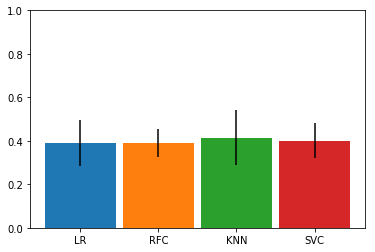

3it [00:00, 28.49it/s]

Best model: 
KNN
classifier__weights = distance
classifier__n_neighbors = 5
dim_reduction = PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
classifier__p = 2

mean = 0.415
std = 0.126589889012


50it [00:01, 31.37it/s]


In [20]:
n_splits = 5
X, y = mri_data, DE_target

best_model_mri_DE, grid_cv_svc_mri_DE, grid_cv_lr_mri_DE, grid_cv_rfc_mri_DE, grid_cv_knn_mri_DE = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=2)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
labels_mri_DE = repeated_cross_val_predict(best_model_mri_DE, X, y, cv, file="labels_mri_DE.csv")

save_model(best_model_mri_DE, "best_model_mri_DE.pkl")

* ### CONN

Training SVC...
(training took 1419.266833305359s)

Training LR...
(training took 45.82218289375305s)

Training RFC...
(training took 1357.9818420410156s)

Training KNN...
(training took 327.52142453193665s)



,best parameters,best dim. reduction method,mean,std
classifier,,,,
LR,classifier__C = 1,"SelectKBest(k=100, score_func=<function ttest_ind at 0x7f6955ad1510>)",0.320,0.090000
RFC,classifier__n_estimators = 300,"SelectKBest(k=50, score_func=<function ttest_ind at 0x7f6955ad1510>)",0.345,0.093408
KNN,"classifier__weights = uniform, classifier__n_neighbors = 13, classifier__p = 2","SelectKBest(k=20, score_func=<function ttest_ind at 0x7f6955ad1510>)",0.335,0.097596
SVC,"classifier__kernel = rbf, classifier__gamma = 0.01, classifier__C = 100","SelectKBest(k=5, score_func=<function f_classif at 0x7f69549dd9d8>)",0.320,0.110000


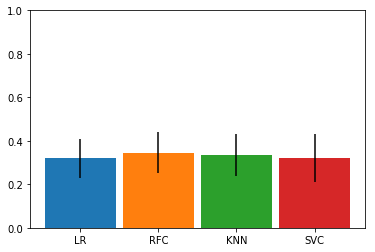

0it [00:00, ?it/s]

Best model: 
RFC
classifier__n_estimators = 300
dim_reduction = SelectKBest(k=50, score_func=<function ttest_ind at 0x7f6955ad1510>)

mean = 0.345
std = 0.0934077084613


50it [00:42,  1.19it/s]


In [21]:
n_splits = 5
X, y = conn, DE_target

best_model_conn_DE, grid_cv_svc_conn_DE, grid_cv_lr_conn_DE, grid_cv_rfc_conn_DE, grid_cv_knn_conn_DE = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=2)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
labels_conn_DE = repeated_cross_val_predict(best_model_conn_DE, X, y, cv, file="labels_conn_DE.csv")

save_model(best_model_conn_DE, "best_model_conn_DE.pkl")

* ### All data

Training SVC...
(training took 2229.3222403526306s)

Training LR...
(training took 53.03340983390808s)

Training RFC...
(training took 1052.5037348270416s)

Training KNN...
(training took 412.03700947761536s)



,best parameters,best dim. reduction method,mean,std
classifier,,,,
LR,classifier__C = 1,"SelectKBest(k=100, score_func=<function ttest_ind at 0x7f6955ad1510>)",0.335,0.077621
RFC,classifier__n_estimators = 300,"SelectKBest(k=50, score_func=<function ttest_ind at 0x7f6955ad1510>)",0.380,0.055678
KNN,"classifier__weights = uniform, classifier__n_neighbors = 9, classifier__p = 1","SelectKBest(k=50, score_func=<function ttest_ind at 0x7f6955ad1510>)",0.370,0.064031
SVC,"classifier__kernel = rbf, classifier__gamma = 1, classifier__C = 1e-06","SelectKBest(k=100, score_func=<function f_classif at 0x7f69549dd9d8>)",0.355,0.101119


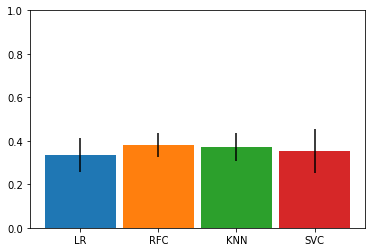

0it [00:00, ?it/s]

Best model: 
RFC
classifier__n_estimators = 300
dim_reduction = SelectKBest(k=50, score_func=<function ttest_ind at 0x7f6955ad1510>)

mean = 0.38
std = 0.0556776436283


50it [00:21,  2.36it/s]


In [22]:
n_splits = 5
X, y = all_data, DE_target

best_model_all_DE, grid_cv_svc_all_DE, grid_cv_lr_all_DE, grid_cv_rfc_all_DE, grid_cv_knn_all_DE = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=2)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
labels_all_DE = repeated_cross_val_predict(best_model_all_DE, X, y, cv, file="labels_all_DE.csv")

save_model(best_model_all_DE, "best_model_all_DE.pkl")

### Epilepsy / no epilepsy

* ### MRI T1

In [24]:
n_splits = 10
X, y = mri_data, E_target

best_model_mri_E, grid_cv_svc_mri_E, grid_cv_lr_mri_E, grid_cv_rfc_mri_E, grid_cv_knn_mri_E = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=2)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
labels_mri_E = repeated_cross_val_predict(best_model_mri_E, X, y, cv, file="labels_mri_E.csv")

save_model(best_model_mri_E, "best_model_mri_E.pkl")

* ### CONN

In [25]:
n_splits = 10
X, y = conn, E_target

best_model_conn_E, grid_cv_svc_conn_E, grid_cv_lr_conn_E, grid_cv_rfc_conn_E, grid_cv_knn_conn_E = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=2)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
labels_conn_E = repeated_cross_val_predict(best_model_conn_E, X, y, cv, file="labels_conn_E.csv")

save_model(best_model_conn_E, "best_model_conn_E.pkl")

* ### All data

In [ ]:
n_splits = 10
X, y = all_data, E_target

best_model_all_E, grid_cv_svc_all_E, grid_cv_lr_all_E, grid_cv_rfc_all_E, grid_cv_knn_all_E = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=2)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
labels_all_E = repeated_cross_val_predict(best_model_all_E, X, y, cv, file="labels_all_E.csv")

save_model(best_model_all_E, "best_model_all_E.pkl")

### Depression / no depression

* ### MRI T1

In [26]:
n_splits = 10
X, y = mri_data, D_target

best_model_mri_D, grid_cv_svc_mri_D, grid_cv_lr_mri_D, grid_cv_rfc_mri_D, grid_cv_knn_mri_D = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=2)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
labels_mri_D = repeated_cross_val_predict(best_model_mri_D, X, y, cv, file="labels_mri_D.csv")

save_model(best_model_mri_D, "best_model_mri_D.pkl")

* ### CONN

In [27]:
n_splits = 10
X, y = conn, D_target

best_model_conn_D, grid_cv_svc_conn_D, grid_cv_lr_conn_D, grid_cv_rfc_conn_D, grid_cv_knn_conn_D = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=2)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
labels_conn_D = repeated_cross_val_predict(best_model_conn_D, X, y, cv, file="labels_conn_D.csv")

save_model(best_model_conn_D, "best_model_conn_D.pkl")

* ### All data

In [ ]:
n_splits = 10
X, y = all_data, D_target

best_model_all_D, grid_cv_svc_all_D, grid_cv_lr_all_D, grid_cv_rfc_all_D, grid_cv_knn_all_D = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=2)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
labels_all_D = repeated_cross_val_predict(best_model_all_D, X, y, cv, file="labels_all_D.csv")

save_model(best_model_all_D, "best_model_all_D.pkl")

### Epilepsy / control

* ### MRI T1

Training SVC...
(training took 303.95731234550476s)

Training LR...
(training took 10.24242377281189s)

Training RFC...
(training took 917.6724207401276s)

Training KNN...
(training took 134.008887052536s)



,best parameters,best dim. reduction method,mean,std
classifier,,,,
LR,classifier__C = 1e-06,"SelectKBest(k=100, score_func=<function ttest_ind at 0x7f6955ad1510>)",0.67,0.167631
RFC,classifier__n_estimators = 300,"SelectKBest(k=10, score_func=<function ttest_ind at 0x7f6955ad1510>)",0.71,0.137477
KNN,"classifier__weights = distance, classifier__n_neighbors = 5, classifier__p = 1","SelectKBest(k=5, score_func=<function ttest_ind at 0x7f6955ad1510>)",0.68,0.107703
SVC,"classifier__kernel = rbf, classifier__gamma = 1, classifier__C = 1e-06","SelectKBest(k=5, score_func=<function ttest_ind at 0x7f6955ad1510>)",0.68,0.188680


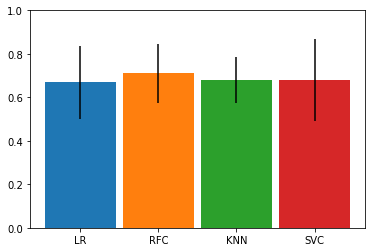

0it [00:00, ?it/s]

Best model: 
RFC
classifier__n_estimators = 300
dim_reduction = SelectKBest(k=10, score_func=<function ttest_ind at 0x7f6955ad1510>)

mean = 0.71
std = 0.137477270849


50it [00:34,  1.45it/s]


In [32]:
n_splits = 5
X, y = mri_data[EC_idx], DE_target[EC_idx]

best_model_mri_EC, grid_cv_svc_mri_EC, grid_cv_lr_mri_EC, grid_cv_rfc_mri_EC, grid_cv_knn_mri_EC = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=2)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
labels_mri_EC = repeated_cross_val_predict(best_model_mri_EC, X, y, cv, file="labels_mri_EC.csv")

save_model(best_model_mri_EC, "best_model_mri_EC.pkl")

* ### CONN

In [34]:
n_splits = 5
X, y = conn[EC_idx], DE_target[EC_idx]

best_model_conn_EC, grid_cv_svc_conn_EC, grid_cv_lr_conn_EC, grid_cv_rfc_conn_EC, grid_cv_knn_conn_EC = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=2)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
labels_conn_EC = repeated_cross_val_predict(best_model_conn_EC, X, y, cv, file="labels_conn_EC.csv")

save_model(best_model_conn_EC, "best_model_conn_EC.pkl")

* ### All data

In [ ]:
n_splits = 5
X, y = all_data[EC_idx], DE_target[EC_idx]

best_model_all_EC, grid_cv_svc_all_EC, grid_cv_lr_all_EC, grid_cv_rfc_all_EC, grid_cv_knn_all_EC = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=2)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
labels_all_EC = repeated_cross_val_predict(best_model_all_EC, X, y, cv, file="labels_all_EC.csv")

save_model(best_model_all_EC, "best_model_all_EC.pkl")

### Depression / control

* ### MRI T1

In [ ]:
n_splits = 5
X, y = mri_data[DC_idx], DE_target[DC_idx]

best_model_mri_DC, grid_cv_svc_mri_DC, grid_cv_lr_mri_DC, grid_cv_rfc_mri_DC, grid_cv_knn_mri_DC = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=2)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
labels_mri_DC = repeated_cross_val_predict(best_model_mri_DC, X, y, cv, file="labels_mri_DC.csv")

save_model(best_model_mri_DC, "best_model_mri_DC.pkl")

* ### CONN

In [29]:
n_splits = 5
X, y = conn[DC_idx], DE_target[DC_idx]

best_model_conn_DC, grid_cv_svc_conn_DC, grid_cv_lr_conn_DC, grid_cv_rfc_conn_DC, grid_cv_knn_conn_DC = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=2)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
labels_conn_DC = repeated_cross_val_predict(best_model_conn_DC, X, y, cv, file="labels_conn_DC.csv")

save_model(best_model_conn_DC, "best_model_conn_DC.pkl")

* ### All data

In [ ]:
n_splits = 5
X, y = all_data[DC_idx], DE_target[DC_idx]

best_model_all_DC, grid_cv_svc_all_DC, grid_cv_lr_all_DC, grid_cv_rfc_all_DC, grid_cv_knn_all_DC = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=2)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
labels_all_DC = repeated_cross_val_predict(best_model_all_DC, X, y, cv, file="labels_all_DC.csv")

save_model(best_model_all_DC, "best_model_all_DC.pkl")

### Epilepsy with depression / only epilepsy

* ### MRI T1

Training SVC...
(training took 244.844055891037s)

Training LR...
(training took 10.326315879821777s)

Training RFC...
(training took 821.5884339809418s)

Training KNN...
(training took 121.74868297576904s)



,best parameters,best dim. reduction method,mean,std
classifier,,,,
KNN,"classifier__p = 1, classifier__weights = distance, classifier__n_neighbors = 11","PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,\n svd_solver='auto', tol=0.0, whiten=False)",0.58,0.132665
LR,classifier__C = 1e-06,"SelectKBest(k=10, score_func=<function ttest_ind at 0x7f45d2d087b8>)",0.63,0.141774
SVC,"classifier__gamma = 1, classifier__C = 1e-06, classifier__kernel = rbf","SelectKBest(k=50, score_func=<function ttest_ind at 0x7f45d2d087b8>)",0.62,0.087178
RFC,classifier__n_estimators = 450,"SelectKBest(k=5, score_func=<function ttest_ind at 0x7f45d2d087b8>)",0.59,0.164012


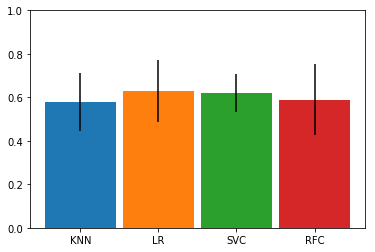

8it [00:00, 75.35it/s]

Best model: 
LR
classifier__C = 1e-06
dim_reduction = SelectKBest(k=10, score_func=<function ttest_ind at 0x7f45d2d087b8>)

mean = 0.63
std = 0.141774468788


50it [00:00, 97.03it/s]


In [17]:
n_splits = 5
X, y = mri_data[DEE_idx], DE_target[DEE_idx]

best_model_mri_DEE, grid_cv_svc_mri_DEE, grid_cv_lr_mri_DEE, grid_cv_rfc_mri_DEE, grid_cv_knn_mri_DEE = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=2)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
labels_mri_DEE = repeated_cross_val_predict(best_model_mri_DEE, X, y, cv, file="labels_mri_DEE.csv")

save_model(best_model_mri_DEE, "best_model_mri_DEE.pkl")

* ### CONN

In [29]:
n_splits = 5
X, y = conn[DEE_idx], DE_target[DEE_idx]

best_model_conn_DEE, grid_cv_svc_conn_DEE, grid_cv_lr_conn_DEE, grid_cv_rfc_conn_DEE, grid_cv_knn_conn_DEE = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=2)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
labels_conn_DEE = repeated_cross_val_predict(best_model_conn_DEE, X, y, cv, file="labels_conn_DEE.csv")

save_model(best_model_conn_DEE, "best_model_conn_DEE.pkl")

* ### All data

In [ ]:
n_splits = 5
X, y = all_data[DEE_idx], DE_target[DEE_idx]

best_model_all_DEE, grid_cv_svc_all_DEE, grid_cv_lr_all_DEE, grid_cv_rfc_all_DEE, grid_cv_knn_all_DEE = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=2)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
labels_all_DEE = repeated_cross_val_predict(best_model_all_DEE, X, y, cv, file="labels_all_DEE.csv")

save_model(best_model_all_DEE, "best_model_all_DEE.pkl")